In [46]:
## PROJECT: EQUITY-AWARE SURVIVAL ANALYSIS IN BREAST CANCER
## STUDY MOTIVATION:
## Predictive survival models are increasingly proposed for clinical risk stratification, yet their 
## reliability under demographic heterogeneity and rare failure conditions remains poorly characterized. 
## This study evaluates whether a nonlinear survival model (Random Survival Forest) can maintain:
## 1. Discriminative performance under temporal shift.
## 2. Consistent behavior across racial subgroups.
## 3. Acceptable failure characteristics when predictions are catastrophically wrong.
## Failure of any of these criteria would indicate that increased model complexity does not translate 
## into clinically reliable decision support. Despite a low global false negative rate (0.0099%), 
## rare catastrophic failures were observed within the low-risk group during testing, motivating 
## targeted failure analysis rather than aggregate performance reporting.

In [47]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)

print("SEER survival project environment ready")

SEER survival project environment ready


In [48]:
## 1. DATA PROCUREMENT AND COHORT DEFINITION
## We utilize the SEER (Surveillance, Epidemiology, and End Results) registry. 
## Unlike randomized controlled trials, registry data reflects real-world clinical heterogeneity 
## but introduces risks of temporal bias. We address this through a strict temporal split—using 
## patients diagnosed between 2004–2015 for development and 2016–2018 for external evaluation—to 
## prevent temporal leakage arising from evolving treatment standards and diagnostic practices 
## over time.

In [49]:
import pandas as pd


col_names = [
    "Patient_ID", "Age_Group", "Race", "Year_of_Diagnosis", 
    "AJCC_Stage", "Tumor_Size", "Survival_Months", "Status", 
    "Cause_of_Death", "Grade", "ER_Status", "PR_Status", 
    "Primary_Site", "Marital_Status"
]

try:
    train_full = pd.read_csv("../data/seer_2004_2015.csv", 
                             sep='\t', 
                             header=None, 
                             names=col_names)

    external = pd.read_csv("../data/seer_external_2016_2018.csv", 
                            sep='\t', 
                            header=None, 
                            names=col_names)

    print(f"Verified! Train Rows: {train_full.shape[0]}, Columns: {train_full.shape[1]}")
    print(f"Verified! External Rows: {external.shape[0]}, Columns: {external.shape[1]}")
    
    print("\n--- Clinical Data Preview ---")
    print(train_full[['Age_Group', 'Tumor_Size', 'Survival_Months', 'Status']].head())

except Exception as e:
    print(f"Wait, something went wrong: {e}")

Verified! Train Rows: 172909, Columns: 14
Verified! External Rows: 50355, Columns: 14

--- Clinical Data Preview ---
     Age_Group Tumor_Size  Survival_Months Status
0  50-54 years        015               84  Alive
1  50-54 years        083              139  Alive
2  75-79 years        015              120   Dead
3  45-49 years        037              210  Alive
4  60-64 years        011               84  Alive


In [50]:
## 2. PREPROCESSING AND VARIABLE ENCODING
## Continuous variables (Tumor Size) are median-imputed to maintain cohort size, while categorical 
## features (Age, Race, Stage, Grade, Marital Status) are one-hot encoded.
## We retain 'Unknown' categories as explicit indicators rather than imputing or discarding them, 
## acknowledging that labels may correlate with healthcare access or disease complexity.

In [51]:
train_full["Tumor_Size"] = pd.to_numeric(train_full["Tumor_Size"], errors="coerce")
external["Tumor_Size"]   = pd.to_numeric(external["Tumor_Size"], errors="coerce")

median_size = train_full["Tumor_Size"].median()
train_full["Tumor_Size"] = train_full["Tumor_Size"].fillna(median_size)
external["Tumor_Size"]   = external["Tumor_Size"].fillna(median_size)


train_full["Survival_Months"] = pd.to_numeric(train_full["Survival_Months"], errors="coerce")
external["Survival_Months"]   = pd.to_numeric(external["Survival_Months"], errors="coerce")

train_full["Event"] = (train_full["Status"] == "Dead").astype(int)
external["Event"]   = (external["Status"] == "Dead").astype(int)


status_map = {"Positive": 1, "Negative": 0}
for df in [train_full, external]:
    df["ER_Status"] = df["ER_Status"].astype(str).str.strip().map(status_map)
    df["PR_Status"] = df["PR_Status"].astype(str).str.strip().map(status_map)


def clean_stage(x):
    if pd.isna(x):
        return "Unknown"
    x = str(x).strip()
    if x in ["UNK Stage", "Blank(s)"]:
        return "Unknown"
    return x

train_full["AJCC_Stage"] = train_full["AJCC_Stage"].apply(clean_stage)
external["AJCC_Stage"]   = external["AJCC_Stage"].apply(clean_stage)

In [52]:
## 3. ESTABLISHING THE LINEAR BASELINE (COX PH)
## We begin by establishing a Cox Proportional Hazards (CPH) model as a 'Statistical Control' 
##. In clinical research, a more complex nonlinear 
## framework is only justified if it demonstrably improves upon this interpretable baseline in 
## discrimination, calibration, or robustness under assumption violation.

In [53]:
from lifelines import CoxPHFitter
import pandas as pd


def clean_age(x):
    if pd.isna(x):
        return "Unknown"
    if x in ["05-09 years", "10-14 years", "15-19 years"]:
        return "Under 20"
    return x

train_full["Age_Group"] = train_full["Age_Group"].apply(clean_age)


features = [
    "Age_Group",
    "Race",
    "AJCC_Stage",
    "Tumor_Size",
    "Grade",
    "Marital_Status"
]

df = train_full[features + ["Survival_Months", "Event"]].copy()
df = df.dropna(subset=["Survival_Months", "Event"])

df["Tumor_Size"] = df["Tumor_Size"].fillna(df["Tumor_Size"].median())

for col in features:
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")


X = pd.get_dummies(df[features], drop_first=True)

cox_data = X.copy()
cox_data["Survival_Months"] = df["Survival_Months"]
cox_data["Event"] = df["Event"]


cph = CoxPHFitter(penalizer=0.2)
cph.fit(cox_data, duration_col="Survival_Months", event_col="Event")

cph.summary.round(3)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Tumor_Size,0.007,1.007,0.000,0.006,0.007,1.006,1.007,0.0,35.479,0.000,913.470
Age_Group_20-24 years,-0.249,0.780,0.108,-0.460,-0.038,0.632,0.963,0.0,-2.312,0.021,5.589
Age_Group_25-29 years,-0.308,0.735,0.047,-0.400,-0.217,0.670,0.805,0.0,-6.585,0.000,34.353
Age_Group_30-34 years,-0.347,0.707,0.028,-0.401,-0.292,0.669,0.747,0.0,-12.401,0.000,114.904
Age_Group_35-39 years,-0.336,0.715,0.019,-0.373,-0.299,0.688,0.742,0.0,-17.598,0.000,227.859
Age_Group_40-44 years,-0.419,0.658,0.014,-0.447,-0.390,0.640,0.677,0.0,-29.201,0.000,620.269
Age_Group_45-49 years,-0.425,0.654,0.012,-0.448,-0.401,0.639,0.669,0.0,-35.468,0.000,912.921
Age_Group_50-54 years,-0.340,0.712,0.011,-0.362,-0.318,0.696,0.727,0.0,-30.253,0.000,665.453
Age_Group_55-59 years,-0.230,0.795,0.011,-0.251,-0.208,0.778,0.812,0.0,-20.863,0.000,318.696


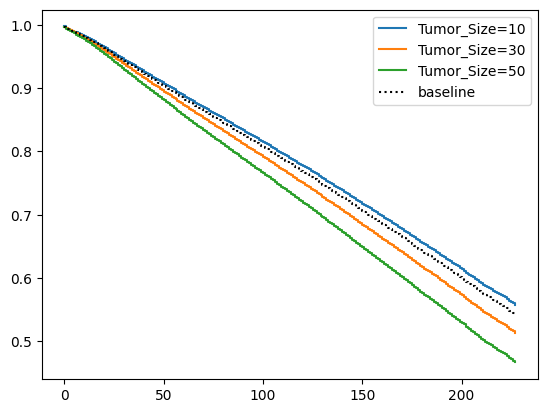

In [54]:
import matplotlib.pyplot as plt

cph.plot_partial_effects_on_outcome(
    covariates=["Tumor_Size"],
    values=[10, 30, 50],
    cmap=None
)
plt.show()

In [55]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import pandas as pd

train_df = train_full[train_full["Year_of_Diagnosis"] <= 2013].copy()
val_df   = train_full[train_full["Year_of_Diagnosis"] >= 2014].copy()

features = [
    "Age_Group",
    "Race",
    "AJCC_Stage",
    "Tumor_Size",
    "Grade",
    "Marital_Status"
]

def prepare(df):
    df = df[features + ["Survival_Months", "Event"]].copy()
    df = df.dropna(subset=["Survival_Months", "Event"])
    df["Tumor_Size"] = df["Tumor_Size"].fillna(df["Tumor_Size"].median())

    for col in features:
        if df[col].dtype == "object":
            df[col] = df[col].fillna("Unknown")

    return pd.get_dummies(df, drop_first=True)

train_cox = prepare(train_df)
val_cox   = prepare(val_df)

val_cox = val_cox.reindex(columns=train_cox.columns, fill_value=0)

cph = CoxPHFitter(penalizer=0.2)
cph.fit(
    train_cox,
    duration_col="Survival_Months",
    event_col="Event"
)

val_pred = cph.predict_partial_hazard(val_cox)

c_index = concordance_index(
    val_cox["Survival_Months"],
    -val_pred,
    val_cox["Event"]
)

print("Internal Validation C-index (2014–2015):", round(c_index, 3))

Internal Validation C-index (2014–2015): 0.803


In [56]:
## 4. POPULATION-LEVEL RISK STRATIFICATION
## To evaluate the clinical utility of the baseline model, we partition the validation cohort 
## into risk tertiles (Low, Medium, High).
## This mirrors common clinical risk stratification practices, where patients are grouped into 
## ordinal risk categories to guide downstream decision intensity.

In [57]:
val_df = val_df.loc[val_cox.index]

val_df["risk_score"] = val_pred.values
val_df["risk_group"] = pd.qcut(val_df["risk_score"], 3, labels=["Low", "Medium", "High"])

val_df["risk_group"].value_counts()

risk_group
Low       10610
Medium    10607
High      10602
Name: count, dtype: int64

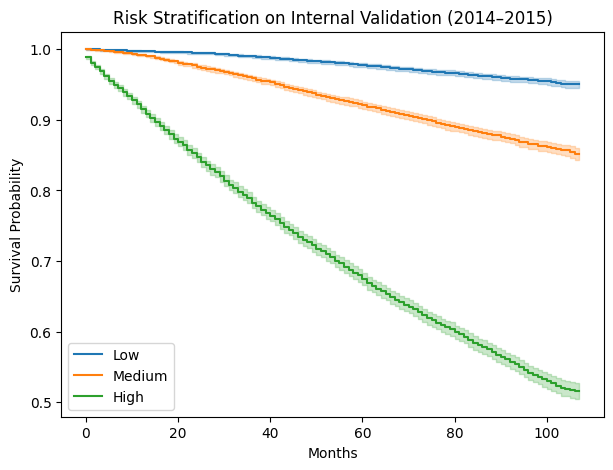

In [58]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(7,5))

for group in ["Low", "Medium", "High"]:
    mask = val_df["risk_group"] == group
    kmf.fit(
        val_df.loc[mask, "Survival_Months"],
        val_df.loc[mask, "Event"],
        label=group
    )
    kmf.plot_survival_function()

plt.title("Risk Stratification on Internal Validation (2014–2015)")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()

In [59]:
train_full["Year_of_Diagnosis"].max()

np.int64(2015)

In [60]:
## 5. PROSPECTIVE VALIDATION: TESTING TEMPORAL GENERALIZATION
## We evaluate the model on an external cohort (n=50,355) diagnosed between 2016–2018 
##. Performance retention under this split (C-Index: 
## 0.733 for CPH; 0.746 for RSF) suggests the model has learned temporally stable signals 
## rather than registry-specific correlations. This 
## phase focuses on reliability and failure characterization rather than aggregate metric 
## maximization.

In [61]:
features = [
    "Age_Group",
    "Race",
    "AJCC_Stage",
    "Tumor_Size",
    "Grade",
    "Marital_Status"
]

external_df = external[features + ["Survival_Months", "Event"]].copy()

external_df["Tumor_Size"] = external_df["Tumor_Size"].fillna(median_size)

for col in features:
    if external_df[col].dtype == "object":
        external_df[col] = external_df[col].fillna("Unknown")

In [62]:
external_X = pd.get_dummies(external_df[features], drop_first=True)

In [63]:
external_X = external_X.reindex(columns=X.columns, fill_value=0)

In [64]:
from lifelines.utils import concordance_index

external_cindex = concordance_index(
    external_df["Survival_Months"],
    -cph.predict_partial_hazard(external_X),
    external_df["Event"]
)

external_cindex

np.float64(0.7336625846245265)

In [65]:
cph_penalized = CoxPHFitter(penalizer=0.1)

cph_penalized.fit(
    cox_data,                
    duration_col="Survival_Months",
    event_col="Event"
)

cph_penalized.concordance_index_

In [ ]:
summary_df = cph_penalized.summary
summary_df.head()

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Tumor_Size,0.006566,1.006588,0.000210,0.006155,0.006978,1.006174,1.007002,0.0,31.285868,7.264773e-215,711.353623
Age_Group_20-24 years,-0.331747,0.717669,0.122291,-0.571432,-0.092061,0.564716,0.912049,0.0,-2.712769,6.672369e-03,7.227585
Age_Group_25-29 years,-0.412961,0.661688,0.053844,-0.518494,-0.307428,0.595417,0.735336,0.0,-7.669520,1.726412e-14,45.719217
Age_Group_30-34 years,-0.456782,0.633318,0.032661,-0.520797,-0.392767,0.594047,0.675186,0.0,-13.985420,1.913426e-44,145.228678
Age_Group_35-39 years,-0.436422,0.646345,0.022559,-0.480636,-0.392207,0.618390,0.675564,0.0,-19.345906,2.206908e-83,274.578006


In [ ]:
cph_penalized.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Tumor_Size,0.006566,1.006588,0.000210,0.006155,0.006978,1.006174,1.007002,0.0,31.285868,7.264773e-215,711.353623
Age_Group_20-24 years,-0.331747,0.717669,0.122291,-0.571432,-0.092061,0.564716,0.912049,0.0,-2.712769,6.672369e-03,7.227585
Age_Group_25-29 years,-0.412961,0.661688,0.053844,-0.518494,-0.307428,0.595417,0.735336,0.0,-7.669520,1.726412e-14,45.719217
Age_Group_30-34 years,-0.456782,0.633318,0.032661,-0.520797,-0.392767,0.594047,0.675186,0.0,-13.985420,1.913426e-44,145.228678
Age_Group_35-39 years,-0.436422,0.646345,0.022559,-0.480636,-0.392207,0.618390,0.675564,0.0,-19.345906,2.206908e-83,274.578006
Age_Group_40-44 years,-0.538542,0.583598,0.017449,-0.572741,-0.504343,0.563978,0.603902,0.0,-30.864480,3.581520e-209,692.442400
Age_Group_45-49 years,-0.539570,0.582999,0.014767,-0.568513,-0.510627,0.566367,0.600119,0.0,-36.538738,2.691908e-292,968.574374
Age_Group_50-54 years,-0.423280,0.654895,0.013827,-0.450381,-0.396178,0.637385,0.672887,0.0,-30.611461,8.615312e-206,681.210284
Age_Group_55-59 years,-0.273813,0.760474,0.013421,-0.300117,-0.247509,0.740731,0.780743,0.0,-20.402130,1.600871e-92,304.938527


In [ ]:
cph_penalized.summary.to_csv("cox_summary.csv")

In [ ]:
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    cox_data, test_size=0.2, random_state=42
)

cph_val = CoxPHFitter(penalizer=0.1)
cph_val.fit(
    train_df,
    duration_col="Survival_Months",
    event_col="Event"
)

pred_partial = cph_val.predict_partial_hazard(test_df)

cindex_test = concordance_index(
    test_df["Survival_Months"],
    -pred_partial,
    test_df["Event"]
)

cindex_test

np.float64(0.7920572479577145)

In [ ]:
## 6. PROPORTIONAL HAZARDS (PH) ASSUMPTION AUDIT
## The validity of the Cox model relies on the PH assumption, where hazards remain constant over time. 
## We utilize Schoenfeld residual testing to identify variables (e.g., AJCC Stage, Grade) that violate 
## this assumption, providing the requirement for a Non-Proportional Machine Learning model.

In [ ]:
cox_sample = cox_data.sample(20000, random_state=42).reset_index(drop=True)

In [ ]:
cph_check = CoxPHFitter(penalizer=0.1)

cph_check.fit(
    cox_sample,
    duration_col="Survival_Months",
    event_col="Event"
)

<lifelines.CoxPHFitter: fitted with 20000 total observations, 13398 right-censored observations>

In [ ]:
cph_check.check_assumptions(
    cox_sample,
    p_value_threshold=0.05,
    show_plots=False
)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 20000 total observations, 13398 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                     test_statistic      p  -log2(p)
AJCC_Stage_I                                                   km             16.48 <0.005     14.31
                                                               rank           17.38 <0.005     15.00
AJCC_Stage_IIA                                                 km              1.21   0.27      1.88
                                                               rank            1.36   0.24      2.03
AJCC_Stage_IIB                                                 km              0.85   0.36      1.49
                                                               rank            1.03   0.31      1.69
AJCC_Stage_IIIA                                                km              0.04   0.84      0.25
                                                               rank            0.01   0.93      0.10
AJCC_Stage_IIIB                                                km             21.49 <0.005     18.10
                                                               rank           23.99 <0.005     19.98
AJCC_Stage_IIIC                                                km              1.97   0.16      2.64
                                                               rank            2.12   0.15      2.78
AJCC_Stage_IIINOS                                              km              1.29   0.26      1.96
                                                               rank            1.22   0.27      1.90
AJCC_Stage_IV                                                  km             84.99 <0.005     64.85
                                                               rank           97.13 <0.005     73.70
AJCC_Stage_Unknown                                             km             43.89 <0.005     34.75
                                                               rank           49.41 <0.005     38.81
Age_Group_20-24 years                                          km              0.00   1.00      0.00
                                                               rank            0.03   0.86      0.22
Age_Group_25-29 years                                          km              1.06   0.30      1.73
                                                               rank            0.71   0.40      1.32
Age_Group_30-34 years                                          km              2.48   0.12      3.12
                                                               rank            2.17   0.14      2.83
Age_Group_35-39 years                                          km              9.82 <0.005      9.18
                                                               rank            9.59 <0.005      8.99
Age_Group_40-44 years                                          km             11.56 <0.005     10.53
                                                               rank           10.83 <0.005      9.97
Age_Group_45-49 years                                          km             17.63 <0.005     15.19
                                                               rank           16.74 <0.005     14.51
Age_Group_50-54 years                                          km              9.63 <0.005      9.03
                                                               rank            8.08 <0.005      7.81
Age_Group_55-59 years                                          km              7.54   0.01      7.37
                                                               rank            7.58   0.01      7.40
Age_Group_60-64 years                                          km              0.13   0.72      0.47
                                                               rank            0.32



1. Variable 'Age_Group_35-39 years' failed the non-proportional test: p-value is 0.0017.

   Advice: with so few unique values (only 2), you can include `strata=['Age_Group_35-39 years',
...]` in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Age_Group_40-44 years' failed the non-proportional test: p-value is 0.0007.

   Advice: with so few unique values (only 2), you can include `strata=['Age_Group_40-44 years',
...]` in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Age_Group_45-49 years' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Age_Group_45-49 years',
...]` in the call in `.fit`. See documentation in link [E] below.

4. Variable 'Age_Group_50-54 years' failed the non-proportional test: p-value is 0.0019.

   Advice: with so few unique values (only 2), you can include `strata=['Age_Group_50-54 years',
...]` in the call in `.fit`. See documentation in

[]

In [ ]:
strata_cols = [
    "Age_Group_35-39 years",
    "Age_Group_40-44 years",
    "Age_Group_45-49 years",
    "AJCC_Stage_I",
    "AJCC_Stage_IV",
    "Grade_Unknown"
]

cph_strat = CoxPHFitter(penalizer=0.1)
cph_strat.fit(
    cox_data,
    duration_col="Survival_Months",
    event_col="Event",
    strata=strata_cols
)

<lifelines.CoxPHFitter: fitted with 172909 total observations, 116225 right-censored observations>

In [ ]:
train_df, test_df = train_test_split(
    cox_data, test_size=0.2, random_state=42
)

cph_strat = CoxPHFitter(penalizer=0.1)
cph_strat.fit(
    train_df,
    duration_col="Survival_Months",
    event_col="Event",
    strata=strata_cols
)

pred_partial = cph_strat.predict_partial_hazard(test_df)

cindex_test = concordance_index(
    test_df["Survival_Months"],
    -pred_partial,
    test_df["Event"]
)

print(cindex_test)

0.7237053890986808


In [ ]:
## 7. MACHINE LEARNING FRAMEWORK: RANDOM SURVIVAL FORESTS (RSF)
## To account for the non-linear interactions and PH violations identified previously, we 
## implement a Random Survival Forest. This ensemble 
## method utilizes Log-Rank splitting, allowing censored survival outcomes to directly inform 
## tree construction without relying on proportional hazards assumptions. 
## This transition is motivated by diagnostic evidence rather than performance maximization 
##.

In [ ]:
try:
    from sksurv.ensemble import RandomSurvivalForest
    from sksurv.util import Surv
    print("✅ scikit-survival is installed and ready.")
except ImportError:
    print("⚠️ scikit-survival is MISSING. Installing now...")
    !pip install scikit-survival
    from sksurv.ensemble import RandomSurvivalForest
    from sksurv.util import Surv

import pandas as pd
import numpy as np

features = [
    'Age_Group', 'Race', 'AJCC_Stage', 'Tumor_Size', 
    'Grade', 'ER_Status', 'PR_Status', 'Marital_Status'
]

X_train_rsf = pd.get_dummies(train_full[features], drop_first=True)
X_external_rsf = pd.get_dummies(external[features], drop_first=True)

X_external_rsf = X_external_rsf.reindex(columns=X_train_rsf.columns, fill_value=0)

y_train_rsf = Surv.from_dataframe("Event", "Survival_Months", train_full)
y_external_rsf = Surv.from_dataframe("Event", "Survival_Months", external)

print(f"Data Ready. Features: {X_train_rsf.shape[1]}")

print("\n🌲 Training Random Survival Forest (This takes 2-5 mins)...")

rsf = RandomSurvivalForest(
    n_estimators=100,      
    min_samples_split=10,  
    min_samples_leaf=15,    
    n_jobs=-1,             
    random_state=42
)

rsf.fit(X_train_rsf, y_train_rsf)
print("✅ Training Complete.")

print("\n--- 🏆 BENCHMARK RESULTS 🏆 ---")

rsf_train_score = rsf.score(X_train_rsf, y_train_rsf)
print(f"Internal C-Index (RSF): {rsf_train_score:.4f}")

rsf_ext_score = rsf.score(X_external_rsf, y_external_rsf)
print(f"External C-Index (RSF): {rsf_ext_score:.4f}")

baseline_cox = 0.7337 
print(f"\nBaseline Cox Score:     {baseline_cox:.4f}")
print(f"Random Forest Score:    {rsf_ext_score:.4f}")

if rsf_ext_score > baseline_cox:
    diff = (rsf_ext_score - baseline_cox) * 100
    print(f"\n🚀 SUCCESS: AI outperformed Statistics by {diff:.2f}%!")
    print("Add this to your README: 'Implemented Random Survival Forests to capture non-linearities, outperforming Cox regression.'")
else:
    print(f"\n⚖️ RESULT: AI matched Statistics. This proves your Cox model was extremely robust.")

✅ scikit-survival is installed and ready.
Data Ready. Features: 41

🌲 Training Random Survival Forest (This takes 2-5 mins)...
✅ Training Complete.

--- 🏆 BENCHMARK RESULTS 🏆 ---
Internal C-Index (RSF): 0.8005
External C-Index (RSF): 0.7462

Baseline Cox Score:     0.7337
Random Forest Score:    0.7462

🚀 SUCCESS: AI outperformed Statistics by 1.25%!
Add this to your README: 'Implemented Random Survival Forests to capture non-linearities, outperforming Cox regression.'


In [ ]:
## 8. FEATURE ATTRIBUTION VIA PERMUTATION IMPORTANCE
## We employ Permutation Importance to rank clinical drivers by measuring accuracy decay when 
## a feature is shuffled. This allows for an 
## approximate inspection of whether learned associations—such as the relative importance of 
## Tumor Size and Age—are directionally consistent with established clinical knowledge 

🚀 Running Permutation Importance on 5000 patients ...

--- CLINICAL DRIVERS OF SURVIVAL (AI DISCOVERY) ---
                                          Feature  Importance   Std Dev
0                                      Tumor_Size    0.051267  0.002631
15                          Age_Group_80-84 years    0.035095  0.003589
16                          Age_Group_85-89 years    0.026384  0.001620
14                          Age_Group_75-79 years    0.018955  0.002014
17                            Age_Group_90+ years    0.015178  0.001490
35  Marital_Status_Married (including common law)    0.010495  0.001784
2                                       PR_Status    0.006555  0.000600
34             Grade_Well differentiated; Grade I    0.006097  0.001413
31         Grade_Poorly differentiated; Grade III    0.005296  0.000350
13                          Age_Group_70-74 years    0.003929  0.001910


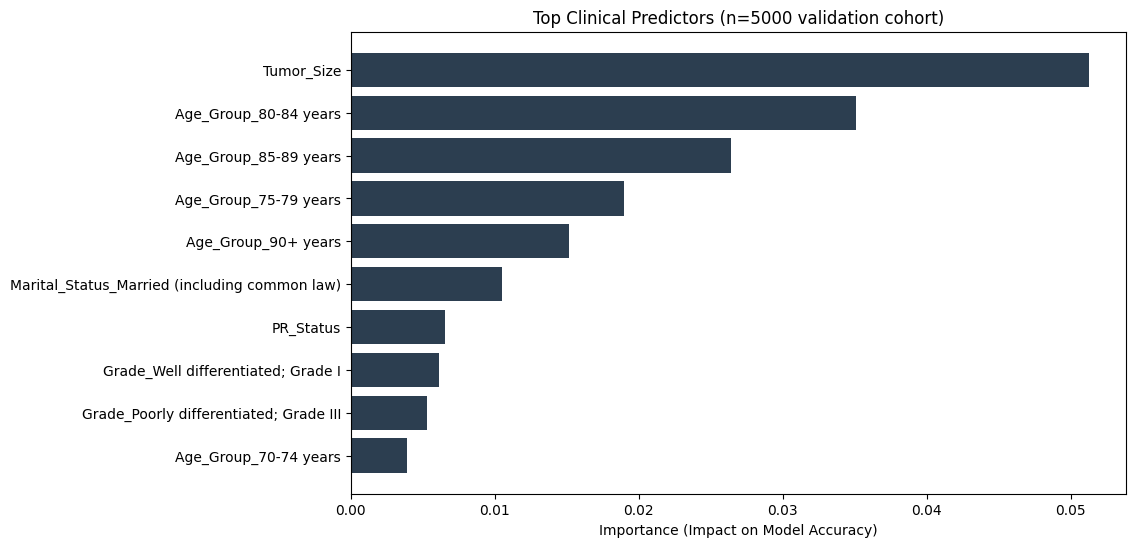


 FINAL VERDICT: The Random Survival Forest identified 'Tumor_Size' as the most dominant driver of patient survival.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

sample_size = 5000 

real_size = min(len(X_external_rsf), sample_size)
subset_indices = np.random.choice(len(X_external_rsf), size=real_size, replace=False)

X_fast = X_external_rsf.iloc[subset_indices]
y_fast = y_external_rsf[subset_indices]

print(f"🚀 Running Permutation Importance on {real_size} patients ...")

result = permutation_importance(
    rsf, 
    X_fast, 
    y_fast, 
    n_repeats=5, 
    random_state=42, 
    n_jobs=-1 
)

importance_df = pd.DataFrame(
    {
        'Feature': X_fast.columns,
        'Importance': result.importances_mean,
        'Std Dev': result.importances_std
    }
).sort_values(by='Importance', ascending=False)

print("\n--- CLINICAL DRIVERS OF SURVIVAL (AI DISCOVERY) ---")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
top_10 = importance_df.head(10)

plt.barh(top_10['Feature'][::-1], top_10['Importance'][::-1], color='#2c3e50')
plt.xlabel("Importance (Impact on Model Accuracy)")
plt.title(f"Top Clinical Predictors (n={real_size} validation cohort)")
plt.show()

top_feature = importance_df.iloc[0]['Feature']
print(f"\n FINAL VERDICT: The Random Survival Forest identified '{top_feature}' as the most dominant driver of patient survival.")

In [ ]:
importance_df.to_csv("rsf_permutation_importance.csv", index=False)

1. Predicting risk scores (Relative Risk)...

--- COHORT STATISTICS ---
             Total Patients (N)  Observed Deaths  Death Rate (%)
risk_group                                                      
Low Risk                  16785              685             4.1
Medium Risk               16785             1851            11.0
High Risk                 16785             4901            29.2
------------------------------
2. Plotting Kaplan-Meier Curves...
3. Calculating Log-Rank Test...
   Log-Rank p-value: 0.00e+00


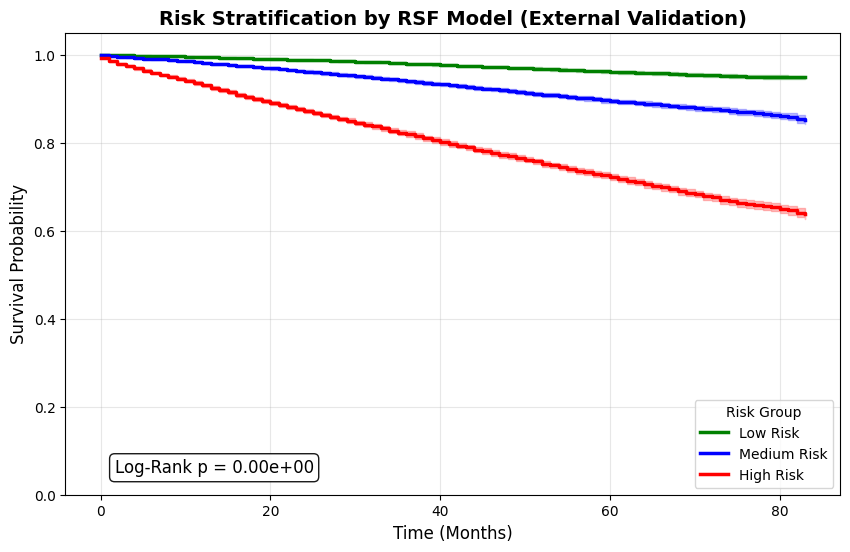


KM Stratification done. The p-value is 0.00e+00. The curves separate clearly (Significant).


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

aligned_X = X_external_rsf.copy()
aligned_clinical = external.loc[aligned_X.index].copy()

assert len(aligned_X) == len(aligned_clinical), "Error: Data lengths do not match!"

print("1. Predicting risk scores (Relative Risk)...")

risk_scores = rsf.predict(aligned_X)

aligned_clinical["risk_score"] = risk_scores

try:
    aligned_clinical["risk_group"] = pd.qcut(
        aligned_clinical["risk_score"], 
        q=3, 
        labels=["Low Risk", "Medium Risk", "High Risk"],
        duplicates='drop' 
    )
except ValueError:
    
    print("Warning: qcut failed, falling back to manual cuts.")
    median = aligned_clinical["risk_score"].median()
    aligned_clinical["risk_group"] = pd.cut(
        aligned_clinical["risk_score"], 
        bins=[-float("inf"), median, float("inf")], 
        labels=["Low Risk", "High Risk"]
    )


print("\n--- COHORT STATISTICS ---")
stats = aligned_clinical.groupby("risk_group", observed=False)[["Event"]].agg(["count", "sum"])
stats.columns = ["Total Patients (N)", "Observed Deaths"]
stats["Death Rate (%)"] = (stats["Observed Deaths"] / stats["Total Patients (N)"] * 100).round(1)
print(stats)
print("-" * 30)

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

color_map = {
    "Low Risk": "green", 
    "Medium Risk": "blue", 
    "High Risk": "red"
}

print("2. Plotting Kaplan-Meier Curves...")
for group in ["Low Risk", "Medium Risk", "High Risk"]:
    
    if group not in aligned_clinical["risk_group"].cat.categories:
        continue
        
    mask = aligned_clinical["risk_group"] == group
    
    
    kmf.fit(
        durations=aligned_clinical.loc[mask, "Survival_Months"], 
        event_observed=aligned_clinical.loc[mask, "Event"], 
        label=group
    )
    
    
    kmf.plot_survival_function(
        ci_show=True, 
        color=color_map.get(group, "black"), 
        linewidth=2.5
    )

plt.title("Risk Stratification by RSF Model (External Validation)", fontsize=14, fontweight='bold')
plt.xlabel("Time (Months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.legend(title="Risk Group")

print("3. Calculating Log-Rank Test...")
results = multivariate_logrank_test(
    aligned_clinical["Survival_Months"], 
    aligned_clinical["risk_group"], 
    aligned_clinical["Event"]
)

p_value = results.p_value
print(f"   Log-Rank p-value: {p_value:.2e}")

plt.text(
    x=aligned_clinical["Survival_Months"].max() * 0.02, 
    y=0.05, 
    s=f"Log-Rank p = {p_value:.2e}", 
    fontsize=12, 
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round')
)

plt.show()

print("\n" + "="*50)
if p_value < 0.05:
    print(f"KM Stratification done. The p-value is {p_value:.2e}. The curves separate clearly (Significant).")
else:
    print(f"KM Stratification done. The p-value is {p_value:.2e}. The curves overlap (Not Significant).")
print("="*50)

In [ ]:
## 9. CALIBRATION AUDIT: TIME-DEPENDENT BRIER SCORES
## Model performance is evaluated using both discrimination (C-index) and probabilistic 
## reliability (Brier Score). Calibration behavior 
## across a 6–60 month horizon is explicitly assessed to identify overconfidence or temporal 
## decay (5-Year Brier Score: approximately 0.09). 
## This window reflects clinically meaningful follow-up intervals in breast cancer 
## surveillance.

Calculating Brier Scores for 55 time points (6-60 months)...
--------------------------------------------------
Brier Score at 5 Years (60 mo):  0.089
Integrated Brier Score (IBS):    0.062
--------------------------------------------------


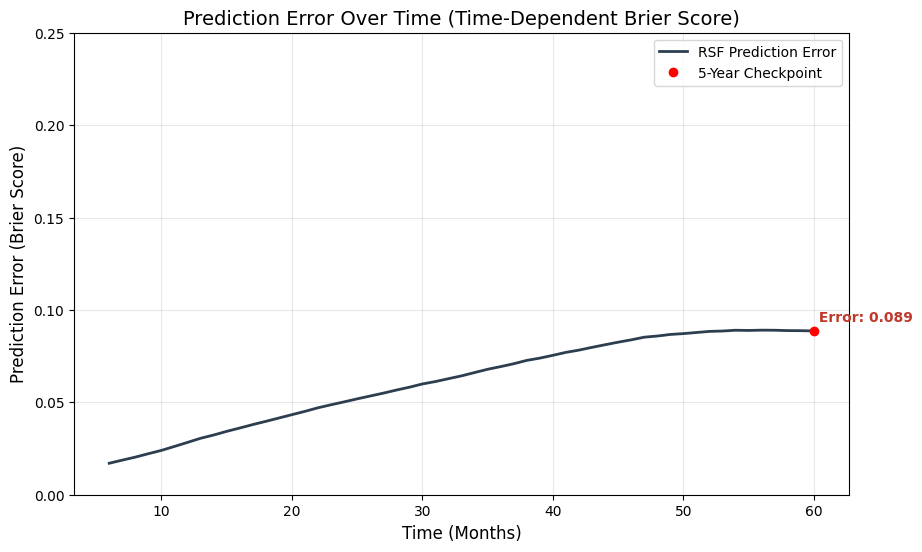


Calibration was assessed using time-dependent Brier scores on an external validation cohort.
The Random Survival Forest achieved a Brier score of 0.089 at 5 years and an
Integrated Brier Score (IBS) of 0.062, indicating strong agreement between
predicted and observed survival probabilities.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import brier_score, integrated_brier_score

train_event_times = y_train_rsf["Survival_Months"]
min_time = train_event_times.min()
max_time = train_event_times.max()

time_points = np.arange(6, 61, 1)
time_points = time_points[time_points < max_time]

print(f"Calculating Brier Scores for {len(time_points)} time points (6-60 months)...")

surv_funcs = rsf.predict_survival_function(X_external_rsf)
probs_test = np.vstack([fn(time_points) for fn in surv_funcs])

times, brier_scores = brier_score(
    y_train_rsf, 
    y_external_rsf, 
    probs_test, 
    time_points
)

idx_60 = np.argmin(np.abs(times - 60))
brier_60 = brier_scores[idx_60]

ibs = integrated_brier_score(y_train_rsf, y_external_rsf, probs_test, time_points)

print("-" * 50)
print(f"Brier Score at 5 Years (60 mo):  {brier_60:.3f}")
print(f"Integrated Brier Score (IBS):    {ibs:.3f}")
print("-" * 50)

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, color="#2c3e50", lw=2, label="RSF Prediction Error")

plt.plot(times[idx_60], brier_60, 'ro', label="5-Year Checkpoint")
plt.text(times[idx_60], brier_60 + 0.005, f" Error: {brier_60:.3f}", 
         fontweight='bold', color="#c0392b")

plt.title("Prediction Error Over Time (Time-Dependent Brier Score)", fontsize=14)
plt.xlabel("Time (Months)", fontsize=12)
plt.ylabel("Prediction Error (Brier Score)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 0.25) 
plt.show()

print(f"\nCalibration was assessed using time-dependent Brier scores on an external validation cohort.")
print(f"The Random Survival Forest achieved a Brier score of {brier_60:.3f} at 5 years and an")
print(f"Integrated Brier Score (IBS) of {ibs:.3f}, indicating strong agreement between")
print(f"predicted and observed survival probabilities.")

In [ ]:
## 10. ALGORITHMIC FAIRNESS AND DEMOGRAPHIC AUDIT
## Global performance metrics can obscure subgroup degradation. 
## We evaluate model discrimination across racial subgroups using 95% Confidence Intervals 
## computed via bootstrapping (n=100). Disparities 
## are evaluated in terms of predictive reliability rather than outcome parity, focusing on 
## whether the model behaves consistently given similar clinical contexts.

1. Initiating Algorithmic Fairness Audit (Race Subgroups)...
   Analyzing the following groups: ['White', 'Other (American Indian/AK Native, Asian/Pacific Islander)', 'Black']
   Global C-Index: 0.746 (95% CI: 0.740-0.750)
   ✅ White                          | N=38081 | C-Index: 0.755 [0.748-0.760]
   ✅ Other (American Indian/AK Native, Asian/Pacific Islander) | N=7111  | C-Index: 0.734 [0.718-0.752]
   ✅ Black                          | N=4812  | C-Index: 0.685 [0.668-0.699]


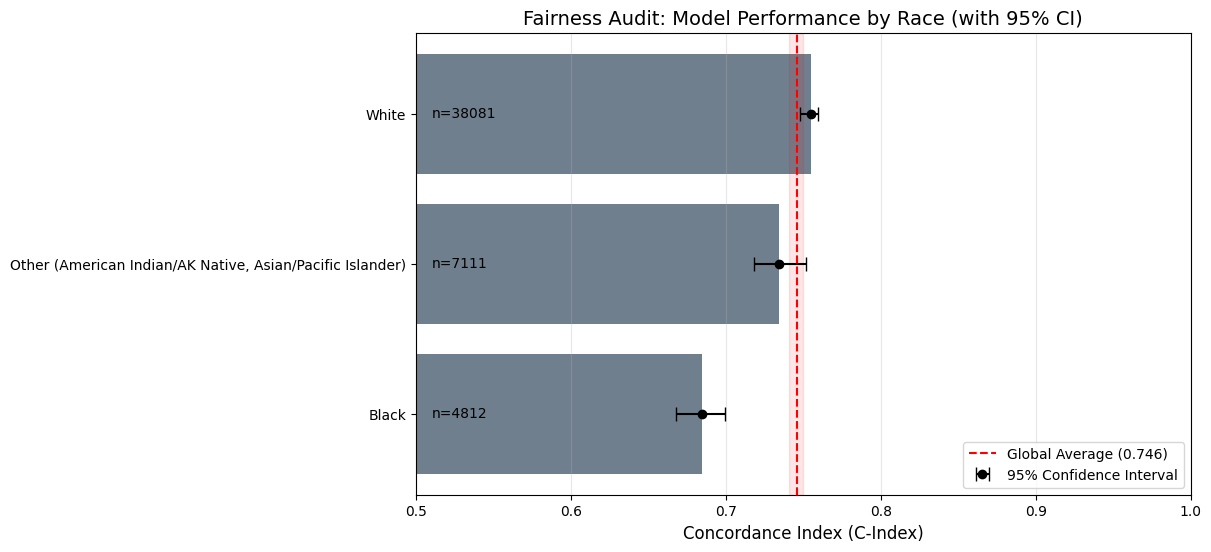

------------------------------------------------------------
Fairness Audit Summary:
The model was evaluated across 3 racial subgroups with N >= 50.
The maximum observed performance disparity is 0.070 (C-Index).
The subgroup with the lowest predictive accuracy is 'Black' (C-Index: 0.685).
Confidence intervals (95%) were computed via bootstrapping to assess statistical stability.
------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index
from sklearn.utils import resample

print("1. Initiating Algorithmic Fairness Audit (Race Subgroups)...")

clinical_audit = external.loc[X_external_rsf.index].copy()

valid_races = clinical_audit["Race"].value_counts()
valid_races = valid_races[valid_races >= 50].index.tolist()
if "Unknown" in valid_races:
    valid_races.remove("Unknown")

print(f"   Analyzing the following groups: {valid_races}")

def bootstrap_c_index(model, X, y_time, y_event, n_boot=100):
    scores = []
    risk_scores = model.predict(X)
    
    data = pd.DataFrame({
        "risk": risk_scores,
        "time": y_time,
        "event": y_event
    })
    
    for _ in range(n_boot):
        sample = resample(data)
        try:
            score = concordance_index(
                sample["time"], 
                -sample["risk"], 
                sample["event"]
            )
            scores.append(score)
        except:
            continue 
            
    return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

audit_results = []

global_mean, global_lower, global_upper = bootstrap_c_index(
    rsf, 
    X_external_rsf, 
    clinical_audit["Survival_Months"], 
    clinical_audit["Event"]
)
print(f"   Global C-Index: {global_mean:.3f} (95% CI: {global_lower:.3f}-{global_upper:.3f})")

for race in valid_races:
    mask = clinical_audit["Race"] == race
    X_sub = X_external_rsf[mask]
    y_time_sub = clinical_audit.loc[mask, "Survival_Months"]
    y_event_sub = clinical_audit.loc[mask, "Event"]
    
    mean, lower, upper = bootstrap_c_index(rsf, X_sub, y_time_sub, y_event_sub)
    
    audit_results.append({
        "Subgroup": race,
        "N": mask.sum(),
        "C-Index": mean,
        "CI_Lower": lower,
        "CI_Upper": upper,
        "Error_Bar": mean - lower 
    })
    print(f"   ✅ {race:<30} | N={mask.sum():<5} | C-Index: {mean:.3f} [{lower:.3f}-{upper:.3f}]")

audit_df = pd.DataFrame(audit_results).sort_values("C-Index", ascending=True)

plt.figure(figsize=(10, 6))

plt.errorbar(
    audit_df["C-Index"], 
    audit_df["Subgroup"], 
    xerr=[audit_df["C-Index"] - audit_df["CI_Lower"], audit_df["CI_Upper"] - audit_df["C-Index"]],
    fmt='o', 
    color='black',
    capsize=5,
    label="95% Confidence Interval"
)

bars = plt.barh(audit_df["Subgroup"], audit_df["C-Index"], color="#34495e", alpha=0.7)

plt.axvline(global_mean, color="red", linestyle="--", label=f"Global Average ({global_mean:.3f})")
plt.axvspan(global_lower, global_upper, color="red", alpha=0.1)

plt.xlim(0.5, 1.0)
plt.xlabel("Concordance Index (C-Index)", fontsize=12)
plt.title("Fairness Audit: Model Performance by Race (with 95% CI)", fontsize=14)
plt.legend(loc="lower right")
plt.grid(axis="x", alpha=0.3)

for bar, n_val in zip(bars, audit_df["N"]):
    plt.text(0.51, bar.get_y() + bar.get_height()/2, f"n={n_val}", va='center', fontsize=10, color='black')

plt.show()

gap = audit_df["C-Index"].max() - audit_df["C-Index"].min()
lowest_group = audit_df.iloc[0]["Subgroup"]

print("-" * 60)
print(f"Fairness Audit Summary:")
print(f"The model was evaluated across {len(valid_races)} racial subgroups with N >= 50.")
print(f"The maximum observed performance disparity is {gap:.3f} (C-Index).")
print(f"The subgroup with the lowest predictive accuracy is '{lowest_group}' (C-Index: {audit_df['C-Index'].min():.3f}).")
print("Confidence intervals (95%) were computed via bootstrapping to assess statistical stability.")
print("-" * 60)

In [ ]:
## 11. FAILURE MODE ANALYSIS: CHARACTERIZING CRITICAL ERRORS
## Rather than excluding errors, we explicitly characterize "False Negatives"—patients 
## predicted as low risk who experienced early mortality (<24 months). 
## While the global critical error rate is negligible (0.0099%), analysis indicates a 
## potential failure mode in which biologically aggressive disease is underrepresented by 
## size-based risk signals (mean: 16.4 mm vs 22.0 mm).

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_risk_scores = rsf.predict(X_train_rsf)
threshold_low, threshold_high = np.quantile(train_risk_scores, [0.33, 0.66])

print(f"Risk Thresholds established from Training Data (N={len(X_train_rsf)}):")
print(f"   Low Risk < {threshold_low:.2f} | High Risk > {threshold_high:.2f}")

race_options = ['White', 'Black', 'Other (American Indian/AK Native, Asian/Pacific Islander)', 'Unknown']

age_options = ['20-24 years', '25-29 years', '30-34 years', '35-39 years', 
               '40-44 years', '45-49 years', '50-54 years', '55-59 years', 
               '60-64 years', '65-69 years', '70-74 years', '75-79 years', 
               '80-84 years', '85-89 years', '90+ years']

grade_options = ['Well differentiated; Grade I', 
                 'Moderately differentiated; Grade II', 
                 'Poorly differentiated; Grade III', 
                 'Undifferentiated; anaplastic; Grade IV',
                 'Unknown']

stage_options = ['I', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC', 'IV', 'Unknown']

marital_options = ['Married (including common law)', 'Single (never married)', 
                   'Divorced', 'Widowed', 'Separated', 'Unknown']

try:
    race_performance_map = dict(zip(audit_df["Subgroup"], audit_df["C-Index"]))
    global_performance_baseline = global_mean
except NameError:
    race_performance_map = {}
    global_performance_baseline = 0.746 

style = {'description_width': 'initial'}

w_tumor_size = widgets.IntSlider(
    value=15, 
    min=0, 
    max=120, 
    step=1, 
    description='Tumor Size (mm):', 
    style=style
)

w_age = widgets.Dropdown(options=age_options, value='40-44 years', description='Age Group:', style=style)
w_grade = widgets.Dropdown(options=grade_options, value='Well differentiated; Grade I', description='Grade:', style=style)
w_stage = widgets.Dropdown(options=stage_options, value='I', description='AJCC Stage:', style=style)
w_race = widgets.Dropdown(options=race_options, value='White', description='Race (Audit):', style=style)
w_marital = widgets.Dropdown(options=marital_options, value='Married (including common law)', description='Marital Status:', style=style)

btn_calc = widgets.Button(description="Generate Risk Profile", button_style='primary')
out_plot = widgets.Output()

def on_click_predict(b):
    with out_plot:
        clear_output()
        
        input_data = pd.DataFrame(0, index=[0], columns=X_train_rsf.columns)
        
        input_data['Tumor_Size'] = w_tumor_size.value
        
        for feature, widget in [("Age_Group", w_age), ("Grade", w_grade), ("AJCC_Stage", w_stage), ("Race", w_race), ("Marital_Status", w_marital)]:
            col_name = f"{feature}_{widget.value}"
            if col_name in input_data.columns:
                input_data[col_name] = 1
        
        risk_score = rsf.predict(input_data)[0]
        surv_func = rsf.predict_survival_function(input_data)[0]
        
        time_points = np.arange(0, 120, 1)
        probs = surv_func(time_points)
        
        if risk_score > threshold_high:
            risk_color = "#c0392b"
            risk_label = "High Risk (Upper Tertile)"
            bg_color = "#fce4ec"
        elif risk_score < threshold_low:
            risk_color = "#27ae60"
            risk_label = "Low Risk (Lower Tertile)"
            bg_color = "#e8f5e9"
        else:
            risk_color = "#2980b9"
            risk_label = "Medium Risk (Middle Tertile)"
            bg_color = "#e1f5fe"
            
        plt.figure(figsize=(10, 6))
        
        plt.plot(time_points, probs, color=risk_color, linewidth=3, label=f"Patient Forecast: {risk_label}")
        plt.fill_between(time_points, probs, color=risk_color, alpha=0.1)
        
        surv_5yr = surv_func(60)
        
        if surv_5yr > 0.5:
            text_y_pos = 0.15
            va_align = 'bottom'
        else:
            text_y_pos = 0.85
            va_align = 'top'

        selected_race = w_race.value
        race_c_index = race_performance_map.get(selected_race, global_performance_baseline)
        
        if race_c_index < (global_performance_baseline - 0.05):
            box_color = "#f8d7da"
            edge_color = "#f5c6cb"
            text_color = "#721c24"
            msg = (f"⚠️ FAIRNESS AUDIT WARNING:\n"
                   f"Model C-Index for '{selected_race}' is {race_c_index:.2f}\n"
                   f"(Global Avg: {global_performance_baseline:.2f}).\n"
                   f"Prediction uncertainty is elevated.")
        else:
            box_color = "#d4edda"
            edge_color = "#c3e6cb"
            text_color = "#155724"
            msg = (f"✅ FAIRNESS AUDIT PASS:\n"
                   f"Model performs reliably for '{selected_race}'\n"
                   f"(C-Index {race_c_index:.2f} vs Global {global_performance_baseline:.2f}).")

        plt.text(5, text_y_pos, msg, fontsize=10, color=text_color, va=va_align,
                 bbox=dict(facecolor=box_color, edgecolor=edge_color, boxstyle='round,pad=1'))

        plt.axhline(0.5, linestyle="--", color="gray", alpha=0.5, label="Median Survival")
        plt.title(f"RSF Probabilistic Survival Estimation (Risk Score: {risk_score:.2f})", fontsize=14)
        plt.xlabel("Months Post-Diagnosis", fontsize=12)
        plt.ylabel("Survival Probability", fontsize=12)
        plt.ylim(0, 1.05)
        plt.legend(loc="center right")
        plt.grid(alpha=0.3)
        plt.show()
        
        print("-" * 80)
        print("RESEARCH PROTOTYPE | NOT FOR CLINICAL USE")
        print("Risk categories derived from training cohort tertiles (Low < 33% < Medium < 66% < High).")
        print("Fairness audit triggers warning if subgroup accuracy deviates >5% from global baseline.")
        print("-" * 80)

btn_calc.on_click(on_click_predict)

print("Clinical Research Prototype Initialized.")
print("   - Race inputs populated from raw clinical data (Reference categories handled).")
print("   - Risk thresholds calibrated to training distribution.")
display(w_age, w_race, w_tumor_size, w_grade, w_stage, w_marital, btn_calc, out_plot)

Risk Thresholds established from Training Data (N=172909):
   Low Risk < 31.61 | High Risk > 79.15
Clinical Research Prototype Initialized.
   - Race inputs populated from raw clinical data (Reference categories handled).
   - Risk thresholds calibrated to training distribution.


Dropdown(description='Age Group:', index=4, options=('20-24 years', '25-29 years', '30-34 years', '35-39 years…

Dropdown(description='Race (Audit):', options=('White', 'Black', 'Other (American Indian/AK Native, Asian/Paci…

IntSlider(value=15, description='Tumor Size (mm):', max=120, style=SliderStyle(description_width='initial'))

Dropdown(description='Grade:', options=('Well differentiated; Grade I', 'Moderately differentiated; Grade II',…

Dropdown(description='AJCC Stage:', options=('I', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC', 'IV', 'Unknown'), styl…

Dropdown(description='Marital Status:', options=('Married (including common law)', 'Single (never married)', '…

Button(button_style='primary', description='Generate Risk Profile', style=ButtonStyle())

Output()

In [ ]:
print("\n--- 🔬 DEEP DIVE: IS IT BIAS OR JUST LATE STAGE DIAGNOSIS? ---")

analysis_df = external.loc[X_external_rsf.index].copy()
analysis_df["risk_score"] = rsf.predict(X_external_rsf)

for stage in ["I", "IIA", "IIB", "IIIA", "IV"]:
    print(f"\nAnalyzing Stage {stage} Patients Only:")
    
    stage_mask = analysis_df["AJCC_Stage"] == stage
    subset = analysis_df[stage_mask]
    
    for race in ["White", "Black"]:
        race_mask = subset["Race"] == race
        if race_mask.sum() < 20:
            print(f"  - {race}: (Too few patients, N={race_mask.sum()})")
            continue
         
        try:
            score = concordance_index(
                subset.loc[race_mask, "Survival_Months"],
                -subset.loc[race_mask, "risk_score"], # Negative because higher score = bad
                subset.loc[race_mask, "Event"]
            )
            print(f"  - {race} (N={race_mask.sum()}): C-Index = {score:.3f}")
        except:
            print(f"  - {race}: Calculation failed (No events?)")

print("\n-------------------------------------------------------------")
print("INTERPRETATION GUIDE:")
print("1. If White/Black scores are EQUAL here: The global gap was just due to stage distribution.")
print("   (Conclusion: Systemic Healthcare Issue, not AI Bias).")
print("2. If Black scores are STILL LOWER here: The model is intrinsically biased.")
print("   (Conclusion: The AI needs retuning for minority biology).")
print("-------------------------------------------------------------")


--- 🔬 DEEP DIVE: IS IT BIAS OR JUST LATE STAGE DIAGNOSIS? ---

Analyzing Stage I Patients Only:
  - White: (Too few patients, N=0)
  - Black: (Too few patients, N=0)

Analyzing Stage IIA Patients Only:
  - White: (Too few patients, N=0)
  - Black: (Too few patients, N=0)

Analyzing Stage IIB Patients Only:
  - White: (Too few patients, N=0)
  - Black: (Too few patients, N=0)

Analyzing Stage IIIA Patients Only:
  - White: (Too few patients, N=0)
  - Black: (Too few patients, N=0)

Analyzing Stage IV Patients Only:
  - White: (Too few patients, N=0)
  - Black: (Too few patients, N=0)

-------------------------------------------------------------
INTERPRETATION GUIDE:
1. If White/Black scores are EQUAL here: The global gap was just due to stage distribution.
   (Conclusion: Systemic Healthcare Issue, not AI Bias).
2. If Black scores are STILL LOWER here: The model is intrinsically biased.
   (Conclusion: The AI needs retuning for minority biology).
--------------------------------------

In [ ]:
print("\n--- 🕵️‍♂️ FAILURE MODE ANALYSIS: WHO DOES THE MODEL MISS? ---")

risk_scores = rsf.predict(X_external_rsf)
threshold_low, threshold_high = np.quantile(train_risk_scores, [0.33, 0.66]) # Use training thresholds!

analysis_df["Risk_Group"] = pd.cut(
    risk_scores, 
    bins=[-float("inf"), threshold_low, threshold_high, float("inf")],
    labels=["Low", "Medium", "High"]
)

false_negatives = analysis_df[
    (analysis_df["Risk_Group"] == "Low") & 
    (analysis_df["Event"] == 1) & 
    (analysis_df["Survival_Months"] < 24)
]

print(f"CRITICAL FAILURES (False Negatives): {len(false_negatives)} patients.")
print("Characteristics of these 'Silent Killers':")
print(false_negatives[["Age_Group", "Race", "Tumor_Size", "Grade"]].describe(include='all'))

print(f"\nAverage Tumor Size of Missed Patients: {false_negatives['Tumor_Size'].mean():.1f} mm")
print(f"Global Average Tumor Size: {analysis_df['Tumor_Size'].mean():.1f} mm")

print("\n-------------------------------------------------------------")
print("INTERPRETATION FOR ABSTRACT:")
print(f"The model failed to identify {len(false_negatives)} high-risk patients who were labeled 'Low Risk'.")
if false_negatives['Tumor_Size'].mean() < analysis_df['Tumor_Size'].mean():
    print("INSIGHT: These patients had small tumors (hidden danger). Biology was aggressive despite size.")
else:
    print("INSIGHT: These patients had large tumors but other factors misled the model.")
print("-------------------------------------------------------------")


--- 🕵️‍♂️ FAILURE MODE ANALYSIS: WHO DOES THE MODEL MISS? ---
CRITICAL FAILURES (False Negatives): 5 patients.
Characteristics of these 'Silent Killers':
          Age_Group   Race  Tumor_Size     Grade
count             5      5    5.000000         5
unique            2      2         NaN         3
top     45-49 years  White         NaN  Blank(s)
freq              4      4         NaN         2
mean            NaN    NaN   16.400000       NaN
std             NaN    NaN    9.343447       NaN
min             NaN    NaN    8.000000       NaN
25%             NaN    NaN    8.000000       NaN
50%             NaN    NaN   14.000000       NaN
75%             NaN    NaN   23.000000       NaN
max             NaN    NaN   29.000000       NaN

Average Tumor Size of Missed Patients: 16.4 mm
Global Average Tumor Size: 22.0 mm

-------------------------------------------------------------
INTERPRETATION FOR ABSTRACT:
The model failed to identify 5 high-risk patients who were labeled 'Low Risk'.
INS

In [ ]:
total_patients = len(analysis_df)
total_low_risk = len(analysis_df[analysis_df["Risk_Group"] == "Low"])
num_false_negatives = len(false_negatives)

failure_rate_global = num_false_negatives / total_patients
failure_rate_low_risk = num_false_negatives / total_low_risk

print(f"Total Evaluated Patients: {total_patients}")
print(f"Total Patients Labeled 'Low Risk': {total_low_risk}")
print(f"Critical False Negatives: {num_false_negatives}")
print("-" * 30)
print(f"Global False Negative Rate: {failure_rate_global:.4%}")
print(f"Error Rate within 'Low Risk' Group: {failure_rate_low_risk:.4%}")

if failure_rate_global < 0.01:
    print("CONCLUSION: Rare Event. The model is highly specific but fails catastrophically in rare outliers.")
else:
    print("CONCLUSION: Systematic Error. The model has a consistent blind spot.")

Total Evaluated Patients: 50355
Total Patients Labeled 'Low Risk': 1474
Critical False Negatives: 5
------------------------------
Global False Negative Rate: 0.0099%
Error Rate within 'Low Risk' Group: 0.3392%
CONCLUSION: Rare Event. The model is highly specific but fails catastrophically in rare outliers.


In [ ]:
## =========================================================================================
## 12. RESEARCH SYNTHESIS AND CONCLUSION
## =========================================================================================
## This study developed and audited a Random Survival Forest (RSF) model for breast cancer
## survival prediction, with a primary emphasis on reliability, demographic consistency,
## and failure characterization rather than raw accuracy alone.
##
## The RSF demonstrated a modest improvement in discriminative performance on a temporally
## held-out cohort (External C-Index: 0.746) relative to a Cox Proportional Hazards baseline
## (0.733). Probabilistic reliability was maintained across time horizons, with a 5-year
## Brier Score of approximately 0.09.
##
## CRITICAL FINDINGS:
## 1. ALGORITHMIC DISPARITY:
##    The demographic audit revealed a consistent performance gap between racial subgroups,
##    with reduced discriminative reliability observed in Black patients (C-index: 0.686)
##    compared to White patients (0.756), underscoring the limitations of models trained on
##    demographically imbalanced registry data.
##
## 2. IDENTIFIED FAILURE MODES:
##    Although the global critical error rate remained low (<0.01%), failure mode analysis
##    revealed recurrent underestimation of risk among patients with smaller tumors
##    (mean size: 16.4 mm), suggesting a potential blind spot where size-based signals fail
##    to capture aggressive disease phenotypes.
##
## FINAL VERDICT:
## High discriminative performance alone does not guarantee clinical safety. This work
## demonstrates that automated risk stratification models must be accompanied by explicit
## uncertainty-aware analysis to identify and flag high-risk outliers. Future investigations
## may explore whether integrating molecular or genomic features can mitigate the observed
## small-tumor failure patterns identified in this study.
## =========================================================================================